In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt

# Preprocessing

In [2]:
df = pd.read_csv('fen_analysis.csv').sample(frac=1)[:30000] # This shuffles the rows
df

,fen_value,score
84703,8/3p4/1p2k2p/8/4ppPP/1N3R2/5R2/6K1 b - - 0 40,-528
112978,r1bq1rk1/pppn1pb1/2n4p/3pp1p1/3P4/2PBPNBP/PP1N...,64
44463,rnb1kbnr/pppp1ppp/4p3/8/3PP2q/2N5/PPP2PPP/R1BQ...,-139
252525,r1bqr1k1/p2p2pp/2pb4/2n4n/2PB4/P1N2P1N/2Q1B1PP...,-12
260800,rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBN...,27
...,...,...
168197,r5k1/1pp2pp1/p6p/5q2/2PKrP2/1P4P1/P3N3/4R3 w -...,-939
171081,rnbqkb1r/pppppppp/5n2/8/8/5N2/PPPPPPPP/RNBQKB1...,26
244669,1rb1kb1r/pp1pppp1/q1p2n1n/7p/1P1N2PP/P1P1P2B/3...,237
107453,2k4r/ppp2ppp/8/8/2N2Pb1/1Pp2N2/P1q3PP/3R1K1R w...,-500


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for fen_i in df['fen_value']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [5]:
X = torch.tensor(fen_encodings, dtype=torch.int32)

In [6]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y = torch.tensor(score_encodings)

In [7]:
X.shape, y.shape

(torch.Size([30000, 70]), torch.Size([30000]))

# Helper Functions

In [8]:
val_split = 10000
test_split = 10000

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device)
    return x, y
# b = get_batch(X, y, 64)

In [11]:
X_val = X[:val_split].to(device)
y_val = y[:val_split].to(device)
X_test = X[val_split:test_split].to(device)
y_test = y[val_split:test_split].to(device)
X = X[test_split:]
y = y[test_split:]

# Training

In [12]:
# hyperparameters
lr = 0.05
num_steps = 1000
bs = 128000*4
# allowed_error = 100 #
d1 = {1:10, 2:20}
if bs > len(X): bs = len(X)

In [13]:
model = MLPEngine(embedding_dim=32).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.AdamW(model.parameters(), lr = lr)
model.compile()

In [23]:
model.train()
train_history = {}
val_history = {}
for step_i in range(num_steps):
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X, y, bs) 
    # print(x_batch, y_batch)
    y_pred = model(x_batch).view(bs)
    # print(y_pred.shape, y_batch.shape)
    loss = loss_category(y_pred, y_batch)
    # print(loss.item())
    train_history[step_i] = loss.item()
    loss.backward()
    optimiser.step()
    print(loss.item())

    if step_i > 200: lr = 0.001

    if step_i % 100 == 0:
        # validation phase
        y_pred = model(X_val).view(val_split)
        # print(y_pred.shape, y_batch.shape)
        loss = loss_category(y_pred, y_val)
        # print(loss.item())
        val_history[step_i] = loss.item()

37606.35546875
28836.08203125
31796.728515625
31337.400390625
36334.640625
35357.2578125
28753.330078125
48420.18359375
42361.33203125
39295.890625
34119.19140625
32544.83203125
32290.107421875
33961.1015625
36439.53515625
29965.41015625
30061.375
27464.90234375
33411.26953125
32554.150390625
31911.51953125
34122.81640625
29139.76953125
35779.7421875
28612.337890625
30544.140625
29468.52734375
39637.1328125
36714.3671875
31401.919921875
31227.62109375
30124.171875
35406.6015625
34161.31640625
34345.015625
32722.197265625
32965.5078125
32303.419921875
30248.197265625
29921.98046875
34860.12109375
31310.220703125
38112.28515625
31248.4921875
31348.97265625
31609.125
29315.142578125
35144.91796875
33884.60546875
28379.369140625
30005.6796875
29569.435546875
29679.470703125
32510.072265625
31444.607421875
31397.88671875
29686.96875
30945.529296875
33169.92578125
28219.4609375
28961.845703125
25787.44921875
35867.98828125
26578.86328125
27616.216796875
31263.556640625
26471.3984375
28576.44

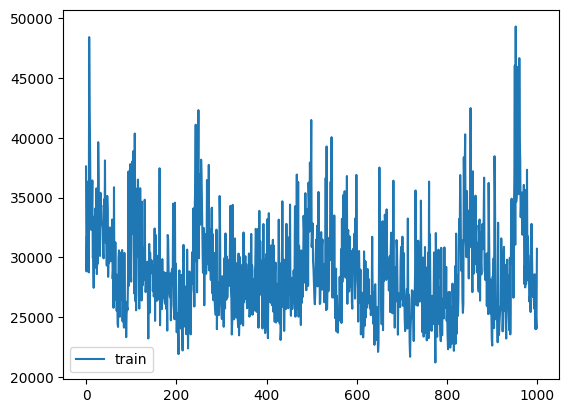

In [24]:
plt.plot(train_history.keys(), train_history.values(), label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [25]:
'''

At relu, model is stuck around 25k

'''

'\n\nAt relu, model is stuck around 25k\n\n'

# Inference

In [16]:
fen_sample ='rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'

In [17]:
def get_score(fen_sample):
    # encoding
    encoder_object = ChessEncoder()
    encoded_fen = torch.tensor(encoder_object.encode_fen(fen_i), dtype=torch.int32).to(device).view(70)
    # print(encoded_fen.shape)
    bs=1
    model = MLPEngine(embedding_dim=32).to(device)
    model.eval()
    y_pred = model(encoded_fen)
    return y_pred.item()
    # run the model

In [18]:
get_score(fen_sample)

-0.180998295545578

In [19]:
32*70

2240

# TODO
- do inference
- evaluate on test dataset
- do some hyperparameter tuning, maybe grid search or something
- look for other/ better dataset
- add regularisation
- add prop initialisation
- Then start to think about architectural changes